# Overview
- histogram in DL-DT
- count for different DL

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
import histlib.erastar as eras
import histlib.stress_to_windterm as stw

from histlib.cstes import labels, zarr_dir
plt.rcParams.update({'font.size':15})

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
from histlib.cstes import labels, zarr_dir

In [3]:
def get_drifter_sat_year_from_label(l):
    L = l.split('_')
    if 'Sentinel' in l:
        return [L[0], L[1]+'_'+L[2], L[-1]]
    else :
        return L

In [4]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.95:8787/status,
Dashboard: http://10.148.0.95:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.95:46925,Workers: 0
Dashboard: http://10.148.0.95:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
cluster.close()

- Geographical repartition
- Number per combinations unfiltered /filtered

In [4]:
zarr_dir_ok = zarr_dir+'_ok'

____________
# HISTOGRAM dl-dt -> need to filter again

In [7]:
l=labels[0]
ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')

In [26]:
ds_data.alti_x.diff(dim='alti_time').mean(dim='alti_time').isel(obs=100).compute()

<xarray.DataArray 'alti_x' ()>
array(6197.53983824)
Coordinates:
    lat      float64 -42.26
    lon      float64 8.213
    obs      int64 100
    time     datetime64[ns] 2020-01-02T06:00:00

In [6]:
DSuf={}
for l in labels: 
    #IMPORT DATA
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')[['alti___time_difference','alti___distance', 'lon', 'lat']]
    DSuf[l]=ds_data.persist()
    print(l)

gps_Jason-3_2020
argos_Jason-3_2020
gps_SARAL_2020
argos_SARAL_2020
gps_Cryosat-2_2020
argos_Cryosat-2_2020
gps_Sentinel-3_A_2020
argos_Sentinel-3_A_2020
gps_Sentinel-3_B_2020
argos_Sentinel-3_B_2020
gps_Jason-3_2019
argos_Jason-3_2019
gps_SARAL_2019
argos_SARAL_2019
gps_Cryosat-2_2019
argos_Cryosat-2_2019
gps_Sentinel-3_A_2019
argos_Sentinel-3_A_2019
gps_Sentinel-3_B_2019
argos_Sentinel-3_B_2019
gps_Jason-3_2018
argos_Jason-3_2018
gps_SARAL_2018
argos_SARAL_2018
gps_Cryosat-2_2018
argos_Cryosat-2_2018
gps_Sentinel-3_A_2018
argos_Sentinel-3_A_2018
gps_Sentinel-3_B_2018
argos_Sentinel-3_B_2018
gps_Jason-3_2017
argos_Jason-3_2017
gps_Jason-2_2017
argos_Jason-2_2017
gps_SARAL_2017
argos_SARAL_2017
gps_Cryosat-2_2017
argos_Cryosat-2_2017
gps_Sentinel-3_A_2017
argos_Sentinel-3_A_2017
gps_Jason-3_2016
argos_Jason-3_2016
gps_Jason-2_2016
argos_Jason-2_2016
gps_SARAL_2016
argos_SARAL_2016
gps_Cryosat-2_2016
argos_Cryosat-2_2016
gps_Sentinel-3_A_2016
argos_Sentinel-3_A_2016
gps_Jason-2_2015
arg

In [7]:
ds= xr.concat([DSuf[l][['alti___time_difference','alti___distance']] for l in labels], dim='obs')
ds['alti___distance'] = (ds.alti___distance/1000).assign_attrs({'units':'km', 'long_name':ds.alti___distance.attrs['long_name']})
ds['alti___time_difference'] = (ds.alti___time_difference/3600).assign_attrs({'units':'h', 'long_name':ds.alti___time_difference.attrs['long_name']})


def scatter_hist(ds,x, y, axi, ax_histx, ax_histy, color='salmon', bins=40, x_label=1, y_label=1, **kwargs,):
    # no labels
    ax.grid(zorder=0)
    ax_histx.grid(axis='x', zorder=0)
    ax_histy.grid(axis='y', zorder=0)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ds.plot.scatter(x, y, color=color, ax=axi, zorder=1, marker='+')
    
    ds[x].plot.hist(bins=np.arange(0,3,1/12), density=True,  color=color, ax=ax_histx, zorder=1)
    ds[y].plot.hist(bins=np.arange(0,600,20), density=True,  color=color, ax=ax_histy, orientation='horizontal', zorder=1)
    ax_histx.set_xlabel('')
    ax_histy.set_xlabel('')

    ax_histx.set_title(**kwargs)
    if isinstance(x_label, str): 
        ax.set_xlabel(x_label)
        ax_histx.set_ylabel('hist('+x_label+')\n')
    if isinstance(y_label, str): 
        ax.set_ylabel(y_label)
        ax_histy.set_xlabel('hist('+y_label+')\n')

    #ax_histx.set_yscale('log')
    #ax_histy.set_xscale('log')

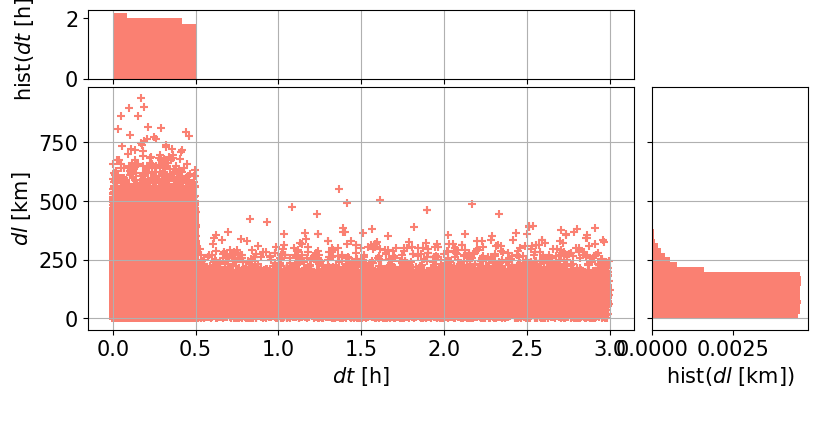

In [8]:
# start with a square Figure
fig = plt.figure(figsize=(9, 4))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(ds, 'alti___time_difference', 'alti___distance', ax, ax_histx, ax_histy,label ='', y_label=r'$dl$ [km]',x_label=r'$dt$ [h]')
#fig.suptitle('(a) \n Colocalisations with GPS drifters\n', fontsize=15)
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
plt.show()

____________
# Count for different dl

In [9]:
DF = {}
for dl in np.array([10,50, 100, 150, 200])*1e3 :
    DS={}
    for l in DSuf :
        DS[l]= DSuf[l].where(DSuf[l].alti___distance<=dl, drop=True)
        DS[l]= DS[l].where(DS[l].alti___time_difference<=3*3600, drop=True)
        #print(DS[l].dims['obs'])
    df = pd.DataFrame(data = [[0]*5]*len(labels), columns=['label', 'drifter_type', 'satellite', 'year', 'number_coloc',])
    i=0
    for l in DS :
        df.iloc[i,:]=[l]+get_drifter_sat_year_from_label(l)+ [DS[l].dims['obs']]
        i+=1
        #df.to_csv()
    DF[dl] = df.groupby('drifter_type').sum().number_coloc

Exception ignored in: <generator object sync.<locals>.f at 0x2aab126ee970>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/utils.py", line 408, in f
    result = yield future
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
DL = list(DF.keys())
dl_argos = [DF[dl].argos for dl in DL]
dl_gps = [DF[dl].gps for dl in DL]
plt.plot(np.array(DL)/1000, dl_argos, label='argos',marker = '+')
plt.plot(np.array(DL)/1000, dl_gps, label='gps', marker='+')
plt.xlabel('dl [km]')
plt.ylabel('Count')
plt.legend()

____________
# Filter out dl> dt>

In [ ]:
DSS={}
for l in DSuf :
    DSS[l]= DSuf[l].where(DSuf[l].alti___distance<=1e5, drop=True)
    DSS[l]= DSS[l].where(DSS[l].alti___time_difference<=3*3600, drop=True)
    #print(DS[l].dims['obs'])

____________
# Count

In [ ]:
df = pd.DataFrame(data = [[0]*5]*len(labels), columns=['label', 'drifter_type', 'satellite', 'year', 'number_coloc',])
i=0
for l in DSS :
    df.iloc[i,:]=[l]+get_drifter_sat_year_from_label(l)+ [DSS[l].dims['obs']]
    i+=1
    #df.to_csv()

In [ ]:
fig = plt.figure(figsize=(20,4))
df.set_index('label').number_coloc.plot.bar(color='teal')
plt.ylabel('Number of colocalizations')
plt.grid()

In [ ]:
df.groupby('drifter_type').sum().number_coloc

In [ ]:
df.groupby('satellite').sum().number_coloc.plot.bar()

In [ ]:
df[df.drifter_type=='gps'].groupby(['year']).sum().number_coloc.plot(label = 'gps')
df[df.drifter_type=='argos'].groupby(['year']).sum().number_coloc.plot(label='argos')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1,1)
sat = df.satellite.unique()
for s in sat : 
    df[df.satellite==s].groupby(['year']).sum().number_coloc.plot(label = s, ax=ax)
ax.legend()

# Geographical repartition

In [ ]:
dl = 5
lon, lat = np.arange(-180, 180+dl, dl), np.arange(-90,90+dl,dl)
bins_lonlat =[lon,lat]

repart_list = []
for key in DS:
    repartition = diag.coloc_repartition(DS[key], bins=bins_lonlat)
    repart_list.append(repartition)
ds_repart = xr.concat(repart_list, dim = pd.Index(name='drifter_sat_year', data=labels))

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size':15})
ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
ax.add_feature(cfeature.LAND, zorder=2)
ds_ = ds_repart.sum(dim='drifter_sat_year')
ds_ = ds_.where(ds_!=0, np.nan)
ds_.rename(f'Number of colocalisations/bins of {dl} °').plot(x="lon_bin", y="lat_bin", ax=ax, transform=ccrs.PlateCarree(),levels=np.arange(500,15000, 500 ), cbar_kwargs={'location':'bottom'})
#ax.set_title('(a)')# \n Colocalisations with GPS drifters')
gl = ax.gridlines(draw_labels=True,)
fig.tight_layout()

In [ ]:
dl = 5
lon, lat = np.arange(-180, 180, dl), np.arange(-90,90,dl)
bins_lonlat =[lon,lat]

repart_list = []
for key in DS:

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    np.log10(ds_repart.sel(drifter_sat_year=key).rename('log(nb coloc /bins '+str(dl) +'°)')).plot(x="lon_bin", y="lat_bin", ax=ax, vmax=2,transform=ccrs.PlateCarree())
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    ax.set_title(key,fontsize=15)
    gl = ax.gridlines()
    fig.suptitle(f"{key} Colocalisations' geographical repartition")

In [ ]:
fg = ds_repart.sum("lon_bin").plot(col='drifter_sat_year', col_wrap=3, figsize=(15,8))
fg.fig.suptitle("Colocalisations' latitudinal repartition")
fg.fig.tight_layout()

## GPS vs Argos

In [ ]:
ds_repart_gps = ds_repart.sel(drifter_sat_year = [l for l in labels if 'gps' in l]).sum(dim='drifter_sat_year')
ds_repart_argos = ds_repart.sel(drifter_sat_year = [l for l in labels if 'argos' in l]).sum(dim='drifter_sat_year')
ds_repart_gps = ds_repart_gps.where(ds_repart_gps!=0, np.nan)
ds_repart_argos = ds_repart_argos.where(ds_repart_argos!=0, np.nan)
DS_={'(a) \n Colocalisations with GPS drifters' : ds_repart_gps, '(b) \n Colocalisations with Argos drifters' : ds_repart_argos}

In [ ]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1,2,1, projection=ccrs.EckertIII(central_longitude=-180))
ax.add_feature(cfeature.LAND, zorder=2)
np.log10(ds_repart_gps.rename('log(nb coloc /bins '+str(dl) +'°)')).plot(x="lon_bin", y="lat_bin", ax=ax, vmax=4,transform=ccrs.PlateCarree())
ax.set_title('(a) \n Colocalisations with GPS drifters', fontsize=15)
gl = ax.gridlines(draw_labels=True,)

ax1 = fig.add_subplot(1,2,2, projection=ccrs.EckertIII(central_longitude=-180))
ax1.add_feature(cfeature.LAND, zorder=2)
np.log10(ds_repart_argos.rename('log(nb coloc /bins '+str(dl) +'°)')).plot(x="lon_bin", y="lat_bin", ax=ax1, vmax=4,transform=ccrs.PlateCarree())
ax1.set_title('(b) \n Colocalisations with Argos drifters', fontsize=15)
gl = ax1.gridlines(draw_labels=True,)

fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size':15})
ax = fig.add_subplot(2,1,1, projection=ccrs.EckertIII(central_longitude=-180))
ax.add_feature(cfeature.LAND, zorder=2)
ds_repart_gps.rename(f'Number of colocalisations/bins of {dl} °').plot(x="lon_bin", y="lat_bin", ax=ax, transform=ccrs.PlateCarree(),levels=np.arange(200,10000, 500 ))
ax.set_title('(a)')# \n Colocalisations with GPS drifters')
gl = ax.gridlines(draw_labels=True,)

ax1 = fig.add_subplot(2,1,2, projection=ccrs.EckertIII(central_longitude=-180))
ax1.add_feature(cfeature.LAND, zorder=2)
ds_repart_argos.rename(f'Number of colocalisations/bins of {dl} °').plot(x="lon_bin", y="lat_bin", ax=ax1, transform=ccrs.PlateCarree(),levels=np.arange(200,10000, 500 ))
ax1.set_title('(b)')# \n Colocalisations with Argos drifters')
gl = ax1.gridlines(draw_labels=True,)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,4), sharey=True)

ds_repart_gps.sum("lon_bin").plot(ax=ax[0], color='salmon')
ax[0].grid( zorder=0)
ax[0].set_title('(a) \n Colocalisations with GPS drifters')
ax[0].set_ylabel('Number of \n colocalisations')
ax[0].set_xlabel('Latitude[°]')
ds_repart_argos.sum("lon_bin").plot(ax=ax[1], color='firebrick')
ax[1].grid( zorder=0)
ax[1].set_title('(b) \n Colocalisations with Argos drifters')
ax[1].set_ylabel('Number of \n colocalisations')
ax[1].set_xlabel('Latitude[°]')
#fig.legend(ncol=4, fontsize=10,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [ ]:
plt.figure(figsize=(8,3))
ds_repart_gps.sum("lon_bin").plot(label='Colocalisations with GPS drifters', color='salmon')
ds_repart_argos.sum("lon_bin").plot(label='Colocalisations with Argos drifters', color='firebrick')
plt.ylabel('Number of \n colocalisations')
plt.xlabel('Latitude[°]')
plt.grid()


In [10]:
cluster.close()